# Sampling Subsets with Gumbel-Top $k$ Relaxations

**Notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/DL2/template/TemplateNotebook.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/DL2/template/TemplateNotebook.ipynb)  
**Author:**
Adeel Pervez

In this part we show how to include a subset sampling component in differentiable models using Gumbel Top $k$ relaxations.
First we show how to build a differentiable subset sampler and then we show one application to differentiable $k$ nearnest neighbor classification.

Formally speaking we are given $N$ elements with weights $w_i$.
We would like to sample $k$ elements from $N$ without replacement.
Stated otherwise, we want a $k$-element subset $S=\{w_{i_1}, w_{i_2},\ldots, w_{i_k}\}$ from $N$ elements.

Given total weight $Z=\sum w_i$, the first element is sampled with probability $\frac{w_{i_1}}{Z}$, the second with probability $\frac{w_{i_2}}{Z-w_{i_1}}$ and so on for $k$ elements.
Multiplying the factors gives the following distribution for $k$ element subsets.

$$ p(S) = \frac{w_{i_1}}{Z}  \frac{w_{i_2}}{Z-w_{i_1}}\cdots \frac{w_{i_k}}{Z-\sum_{j=1}^{k-1} w_{i_j}}.$$

In the introduction we showed how sampling from a categorical distribution could be recast as choosing the argmax of a set of Gumbel random variables.
Relaxing the argmax with a softmax allowed us to approximate sampling from the target categorical distribution. 
A temperature could be used to control the extent of relaxation.
In this case the the categorical probabilities are given by the softmax distrbution
$$p_i = \frac{exp(x_i)}{\sum_j exp(x_j)} = \frac{w_i}{\sum_j w_j}$$

It turns out that by selecting the $k$ largest Gumbel random variables instead of just the largest we can sample subsets according to the sampling without replacement probability given above.
This procedure is closely related to a procedure known by the name of weighted reservoir sampling.

Seen this way, the Gumbel-Argmax trick is a method for sampling subsets of size $k=1$ with probabilities given by $p_i$.
Replacing the argmax by a Top-$k$ procedure for selecting the $k$ largest elements generalizes the Gumbel-Argmax to sample size $k$ subsets with probablity $p(S)$.
In this case we think of the Top-$k$ procedure as returning a $k$-hot vector $y$ where $y_i=1$ if the $i$th element is selected and $y_i=0$ otherwise.
Thus we represent subsets as $k$-hot vectors which also generalizes the representation of categorical samples as 1-hot vectors.

The unrelaxed subset sampling procedure can then be written as follows given non-negative weights $w_i$.

1. Compute keys $\hat{r_i} = -\log(-\log(u_i)) +  \log(w_i)$ for all $i$ and $u_i \in U(0,1)$.
2. Return $k$ largest keys $\hat{r_i}$.

## Top $k$ Relaxation

We can construct an unrelaxed Top $k$ by iteratively applying the softmax $k$ times and sampling a 1-hot categorical sample at each step.
The $k$ 1-hot categorical samples are then combined into a single $k$-vector.
When the categorical sample gives a particular element, the log probablity for that element is set to $-\infty$ for the future iterations so that the element is never chosen again. We can relax this procedure by replacing samples from the softmax by the probabilties computed by softmax. When the softmax temperature is set to be small, the sampled and the relaxed outputs are close.

In more detail the procedure is as follows.

### Unrelaxed Version
For $i=1\ldots n$ and $j=1\ldots k$, set $ \alpha^1_i = \hat{r_i}$ and $\alpha_i^{j+1} = \alpha_i^{j} + \log(1-a_i^j)$

Here $a^j_i$ is a sample the categorical distribution with probabilities $p(a^j_i = 1) = \frac{\exp(\alpha_i^{j}/\tau)}{\sum_k\exp(\alpha_k^{j}/\tau)}$ and $\tau$ is a temperature.

Note that when $a_i^j$ is a 1-hot categorical sample the $\log(1-a_i^j)$ term in the first equation above sets the next $\alpha_i^{j+1}$ to $-\infty$ if $a_i^j=1$ and leaves it unchanged otherwise.
This ensures that the $i$th element once sampled is not sampled in the next steps.
Finally we add all the $k$ vectors as $\sum_j a^j$ and return the output as the sample.


### Relaxed Version
To relax the above procedure we can replace the categorical sample at step by its expectation.
In this case the update becomes

For $i=1\ldots n$ and $j=1\ldots k$, set $ \alpha^1_i = \hat{r_i}$ and $\alpha_i^{j+1} = \alpha_i^{j} + \log(1-p(a_i^j=1))$

where $p(a^j_i = 1) = \frac{\exp(\alpha_i^{j}/\tau)}{\sum_k\exp(\alpha_k^{j}/\tau)}$ as above.
At low values of $\tau$ the softmax distribution becomes close to deterministic outputs a value that is close to $k$-hot.
The temperature variable is a hyperparameter and ideally should be annealed from larger to smaller values during the course of training.
However, in most applications the temperature is left fixed per trial and tuned using cross validation.
Proper tuning of temperature can have a significant effect on the performance of the model.


In the following we use code from [[here](https://github.com/ermongroup/subsets)]

In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, ConcatDataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler

import random
import time
from pathlib import Path

import numpy as np

from dataset import DataSplit
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
gpu = torch.device('cuda')

## Subset Sampler Class

The following `SubsetOperator` class implements the relaxed subset sampling procedure described above.
As described the `forward` method takes a list of scores (unormalized log probs) of some fixed dimension.
We add Gumbel noise with location 0 and scale 1 and divide by the temperature.
Next we apply the Top-$k$ relaxation and return the resulting $k$-hot vector as the sampled subset.


In [3]:
EPSILON = np.finfo(np.float32).tiny

class SubsetOperator(torch.nn.Module):
    def __init__(self, k, tau=1.0, hard=False):
        super(SubsetOperator, self).__init__()
        self.k = k
        self.hard = hard
        self.tau = tau

    def forward(self, scores):
        m = torch.distributions.gumbel.Gumbel(torch.zeros_like(scores), torch.ones_like(scores))
        g = m.sample()
        scores = scores + g

        # continuous top k
        khot = torch.zeros_like(scores)
        onehot_approx = torch.zeros_like(scores)
        for i in range(self.k):
            khot_mask = torch.max(1.0 - onehot_approx, torch.tensor([EPSILON]).cuda())
            scores = scores + torch.log(khot_mask)
            onehot_approx = torch.nn.functional.softmax(scores / self.tau, dim=1)
            khot = khot + onehot_approx

        if self.hard:
            # straight through
            khot_hard = torch.zeros_like(khot)
            val, ind = torch.topk(khot, self.k, dim=1)
            khot_hard = khot_hard.scatter_(1, ind, 1)
            res = khot_hard - khot.detach() + khot
        else:
            res = khot

        return res


You can try the sampler on some example input and various temperatures. Note that the sum of the vectors elements is always $k$.
At lower temperatures the output should be close to $k$-hot.

In [4]:
sampler = SubsetOperator(k=2, tau=1.0)

x = torch.tensor([[1.,2.,3.,4.]]).to(gpu)
y = sampler(x)
print(y, y.sum())

tensor([[0.0300, 0.5041, 0.4979, 0.9679]], device='cuda:0') tensor(2., device='cuda:0')


## Empirical Sampling Distribution

We empirically confirm that the $k$-hot relaxation generates subsets with the same distribution as the sampling without replacement distribution.
For this we define a set with weights in `[1,2,3,4]` and generate 10000 subsets of size 2 using the true distribution (here with Gumbel Top $k$).
Then we generate subsets using the relaxation given above with a fixed temperature.
The samples are plotted side-by-side in a histogram.

In [5]:
w = torch.tensor([[1.,2.,3.,4.]]).to(gpu)
w = w.tile((10000,1))
w_scores = torch.log(w)

Use Gumbel-Top-$k$ to get true distribution samples.

In [6]:
#true samples
m = torch.distributions.gumbel.Gumbel(torch.zeros_like(w_scores), torch.ones_like(w_scores))
g = m.sample()
scores = w_scores + g
samples = torch.topk(scores, 2)[1]
samples = samples.detach().cpu().numpy()
samples = [str(x) for x in samples]

To get samples of subsets from the relaxation, we first apply the relaxation and choose the Top $k$ indices as the chosen subset. 

In [7]:
#relaxed samples
r_samples = sampler(w_scores)

r_samples = torch.topk(r_samples, 2)[1]
r_samples = r_samples.detach().cpu().numpy()
r_samples = [str(x) for x in r_samples]

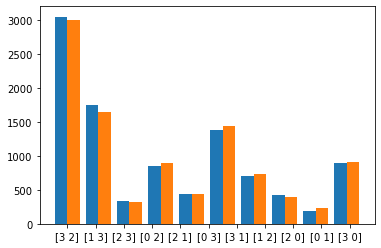

In [8]:
plt.hist([samples,r_samples], align='left')
plt.show()

## Application: Differentiable k Nearest Neighbors

Now we apply the subset sampling procedure to a classification problem with differentiable $k$ nearest neighbors. 
Recall that in $k$ nearest neighbors classification we look at the labels of the $k$ nearest neighbors and take the majority vote for classication.
Unlike the classical form of nearest neigbors, we want to take the feature from a deep network.
The $k$ nearest neighbors loss is cannot be directly used in differentiable models so we relax it with our subset relaxation.
Furthermore instead of looking for the nearest neighbors in the entire dataset (which can be large) we choose a random subset of data points for the distance calculations.

Given a query vectory $q$ and a set $N$ of neighbors we compute the Euclidean distance between the $q$ and each element $i \in N$.
This gives us a list of scores (negative of the distances) and sample a $k$ size subset of these scores as a relaxed $k$-hot vector.

Since this is a classification problem, during training we have the label $y$ for the query vector $q$ and for each of the neighbors $y_i$.
If the labels are equal for a query, neighbor pair, we include the corresponding score otherwise we set it to 0 and take the sum to compute the loss.

Given a subset of $k$ neighbors the loss can be written as 
$$L(S;q) = -\sum_{j\in S} I[y==y_i].$$ 

The actual loss is then the expectation of this expression over all subsets.
$$ L(q) = E_S[L(S;q)].$$

The `SubsetsDKNN` class computes the scores between the queries and neighbors and returns the sampled subsets.

In [9]:
class SubsetsDKNN(torch.nn.Module):
    def __init__(self, k, tau=1.0, hard=False, num_samples=-1):
        super(SubsetsDKNN, self).__init__()
        self.k = k
        self.subset_sample = SubsetOperator(k=k, tau=tau, hard=hard)
        self.num_samples = num_samples

    # query: batch_size x p
    # neighbors: 10k x p
    def forward(self, query, neighbors, tau=1.0):
        diffs = (query.unsqueeze(1) - neighbors.unsqueeze(0))
        squared_diffs = diffs ** 2
        l2_norms = squared_diffs.sum(2)
        norms = l2_norms  # .sqrt() # M x 10k
        scores = -norms

        top_k = self.subset_sample(scores)
        return top_k

The following is the convNet that we use to compute the features of the data examples.

In [10]:

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5, stride=1)
        self.linear = nn.Linear(800, 500)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.linear(out))
        return out

### Define hyperparameters.
Here we say that we are going to using 100 queries per minibatch and 100 neighbors for the distance computation.
The embedding size for each data sample is set to 500.

In [11]:
k = 9
tau = 1.0
NUM_TRAIN_QUERIES = 100
NUM_TEST_QUERIES = 10
NUM_TRAIN_NEIGHBORS = 100
LEARNING_RATE = 10 **-3
NUM_EPOCHS = 20
EMBEDDING_SIZE = 500

In [12]:
dknn_layer = SubsetsDKNN(k, tau)

### Data Sampler

In theory we could use the entire dataset as the set of data points from which to choose the $k$ nearest neighbors for any query data point.
This, however, is expensive so we instead use a random set of data points from which to select the $k$ nearest neighbors.

In the following we define a data sampler class which samples a batch of query samples and a batch of neighbors from which to select the $k$ nearest neighbors for each query.
The size of the query set and the neighbor set is fixed by the `NUM_TRAIN_QUERIES` and the `NUM_TRAIN_NEIGHBORS` hyperparameters defined above.

In [13]:
class ClassicDataset(Dataset):

    def __init__(self,
                 x,
                 y,
                 transform):

        self.xy = TensorDataset(x, y)
        self.transform = transform

    def __len__(self):

        return len(self.xy)

    def __getitem__(self, idx):

        x, y = self.xy[idx]
        if self.transform:
            x = self.transform(x)

        return x, y


class DataSplit(object):
    def __init__(self, dataset):
        if dataset == 'mnist':
            trva_real = datasets.MNIST(root='./data-mnist', download=True)
            tr_real_ds, va_real_ds = random_split(trva_real, [55000, 5000])
            xtr_real = trva_real.train_data[tr_real_ds.indices].view(
                -1, 1, 28, 28)
            ytr_real = trva_real.train_labels[tr_real_ds.indices]
            xva_real = trva_real.train_data[va_real_ds.indices].view(
                -1, 1, 28, 28)
            yva_real = trva_real.train_labels[va_real_ds.indices]

            trans = transforms.Compose(
                [transforms.ToPILImage(), transforms.ToTensor()]
            )

            self.train_dataset = ClassicDataset(
                x=xtr_real, y=ytr_real, transform=trans)
            self.valid_dataset = ClassicDataset(
                x=xva_real, y=yva_real, transform=trans)
            self.test_dataset = datasets.MNIST(root='./data-mnist', train=False, transform=transforms.Compose([
                transforms.ToTensor()
            ]))
            
    def get_train_loader(self, batch_size, **kwargs):
        train_loader = DataLoader(self.train_dataset,
                                  batch_size=batch_size, num_workers=4, shuffle=True, **kwargs)
        return train_loader

    def get_valid_loader(self, batch_size, **kwargs):
        valid_loader = DataLoader(self.valid_dataset,
                                  batch_size=batch_size, shuffle=True, **kwargs)
        return valid_loader

    def get_test_loader(self, batch_size, **kwargs):
        test_loader = DataLoader(self.test_dataset,
                                 batch_size=batch_size, shuffle=False, **kwargs)
        return test_loader


### Loss
Now we compute the loss given the sampled subsets for the queries using the labels for the queries and neighbors.

In [14]:
def dknn_loss(query, neighbors, query_label, neighbor_labels):
    # query: batch_size x p
    # neighbors: 10k x p
    # query_labels: batch_size x [10] one-hot
    # neighbor_labels: n x [10] one-hot

    # num_samples x batch_size x n
    start = time.time()
    top_k_ness = dknn_layer(query, neighbors)
    elapsed = time.time() - start
    correct = (query_label.unsqueeze(1) *
               neighbor_labels.unsqueeze(0)).sum(-1)  # batch_size x n
    correct_in_top_k = (correct.unsqueeze(0) * top_k_ness).sum(-1)
    loss = -correct_in_top_k

    return loss, elapsed

In [15]:
h_phi = ConvNet().to(gpu)

In [16]:
optimizer = torch.optim.SGD(
    h_phi.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=5e-4)


In [17]:
split = DataSplit('mnist')

batched_query_train = split.get_train_loader(NUM_TRAIN_QUERIES)
batched_neighbor_train = split.get_train_loader(NUM_TRAIN_NEIGHBORS)

# labels is a 1-dimensional tensor
def one_hot(labels, l=10):
    n = labels.shape[0]
    labels = labels.unsqueeze(-1)
    oh = torch.zeros(n, l, device='cuda').scatter_(1, labels, 1)
    return oh

/home/apervez/anaconda3/envs/pytorch1.9_2/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/home/apervez/anaconda3/envs/pytorch1.9_2/lib/python3.7/site-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/apervez/anaconda3/envs/pytorch1.9_2/lib/python3.7/site-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels 

### Training

To train we sample a batch of queries and a batch of neighbors and compute the knn loss for each query and display the classification accuracy.

In [18]:
def train(epoch):
    timings = []
    h_phi.train()
    to_average = []
    # train
    for query, candidates in zip(batched_query_train, batched_neighbor_train):
        optimizer.zero_grad()
        cand_x, cand_y = candidates
        query_x, query_y = query

        cand_x = cand_x.to(device=gpu)
        cand_y = cand_y.to(device=gpu)
        query_x = query_x.to(device=gpu)
        query_y = query_y.to(device=gpu)

        neighbor_e = h_phi(cand_x).reshape(NUM_TRAIN_NEIGHBORS, EMBEDDING_SIZE)
        query_e = h_phi(query_x).reshape(NUM_TRAIN_QUERIES, EMBEDDING_SIZE)

        neighbor_y_oh = one_hot(cand_y).reshape(NUM_TRAIN_NEIGHBORS, 10)
        query_y_oh = one_hot(query_y).reshape(NUM_TRAIN_QUERIES, 10)

        losses, timing = dknn_loss(query_e, neighbor_e, query_y_oh, neighbor_y_oh)
        timings.append(timing)
        loss = losses.mean()
        loss.backward()
        optimizer.step()
        to_average.append((-loss).item() / k)

    print('Avg. train correctness of top k:',
          sum(to_average) / len(to_average))


For testing we can directly take the $k$ nearest neighbors and do not sample.

In [19]:
def majority(lst):
    return max(set(lst), key=lst.count)


def new_predict(query, neighbors, neighbor_labels):
    '''
    query: p
    neighbors: n x p
    neighbor_labels: n (int)
    '''
    diffs = (query.unsqueeze(1) - neighbors.unsqueeze(0))  # M x n x p
    squared_diffs = diffs ** 2
    norms = squared_diffs.sum(-1)  # M x n
    indices = torch.argsort(norms, dim=-1)
    labels = neighbor_labels.take(indices[:, :k])  # M x k
    prediction = [majority(l.tolist()) for l in labels]
    return torch.Tensor(prediction).to(device=gpu).long()


def acc(query, neighbors, query_label, neighbor_labels):
    prediction = new_predict(query, neighbors, neighbor_labels)
    return (prediction == query_label).float().cpu().numpy()

In [20]:
batched_query_val = split.get_valid_loader(NUM_TEST_QUERIES)
batched_query_test = split.get_test_loader(NUM_TEST_QUERIES)

def test(epoch, val=False):
    h_phi.eval()
    global best_acc
    with torch.no_grad():
        embeddings = []
        labels = []
        for neighbor_x, neighbor_y in batched_neighbor_train:
            neighbor_x = neighbor_x.to(device=gpu)
            neighbor_y = neighbor_y.to(device=gpu)
            embeddings.append(h_phi(neighbor_x))
            labels.append(neighbor_y)
        neighbors_e = torch.stack(embeddings).reshape(-1, EMBEDDING_SIZE)
        labels = torch.stack(labels).reshape(-1)

        results = []
        for queries in batched_query_val if val else batched_query_test:
            query_x, query_y = queries
            query_x = query_x.to(device=gpu)
            query_y = query_y.to(device=gpu)
            query_e = h_phi(query_x)  # batch_size x embedding_size
            results.append(acc(query_e, neighbors_e, query_y, labels))
        total_acc = np.mean(np.array(results))

    split = 'val' if val else 'test'
    print('Avg. %s acc:' % split, total_acc)


We can now train the model. 
After 20 epochs of training we can get about 99.3% test accuracy.

In [21]:
for t in range(1, NUM_EPOCHS):
    print('Beginning epoch %d: ' % t)
    train(t)
test(-1, val=False)

Beginning epoch 1: 


/home/apervez/anaconda3/envs/pytorch1.9_2/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Avg. train correctness of top k: 0.8229239338094538
Beginning epoch 2: 
Avg. train correctness of top k: 0.946745645253346
Beginning epoch 3: 
Avg. train correctness of top k: 0.9622555222174133
Beginning epoch 4: 
Avg. train correctness of top k: 0.9690864601520575
Beginning epoch 5: 
Avg. train correctness of top k: 0.9729619107101898
Beginning epoch 6: 
Avg. train correctness of top k: 0.9756706522931945
Beginning epoch 7: 
Avg. train correctness of top k: 0.9772672240902679
Beginning epoch 8: 
Avg. train correctness of top k: 0.979861466186215
Beginning epoch 9: 
Avg. train correctness of top k: 0.9812466282314722
Beginning epoch 10: 
Avg. train correctness of top k: 0.9830450813216385
Beginning epoch 11: 
Avg. train correctness of top k: 0.9833505170995545
Beginning epoch 12: 
Avg. train correctness of top k: 0.9849045225586555
Beginning epoch 13: 
Avg. train correctness of top k: 0.9853075543798592
Beginning epoch 14: 
Avg. train correctness of top k: 0.985281333538017
Beginning 

## References

[Reparameterizable Subset Sampling via Continuous Relaxations](https://arxiv.org/abs/1901.10517). [[Code](https://github.com/ermongroup/subsets)]